Investigate how having a lower lmax for the model than for the generated data
affects the results.

In [2]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM

RS = SH.RealSphericalHarmonics()

3072 190


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 190


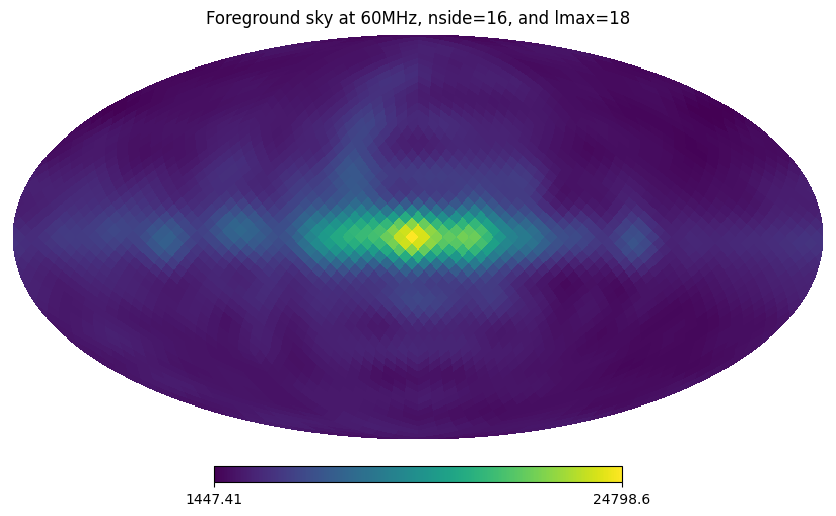

In [3]:
# Create a sky map of the foregrounds.
lmax = 18
nside = 2**4
npix = hp.nside2npix(nside)
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

fg_alm, fg_map = SM.foreground_gdsm_alm(nu=60, lmax=lmax, nside=nside, map=True)
hp.mollview(fg_map, title=f"Foreground sky at 60MHz, nside={nside}, and lmax={lmax}")

# Calculate total observation matrix.
tight_cosbeam = lambda theta: BF.beam_cos(theta, theta0=.8)
mat_A = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax, 
    Ntau=npix, 
    Nt=npix,
    beam_use=tight_cosbeam
)
# Generate data.
data = mat_A @ fg_alm
noisy_data, noise_cov = SM.add_noise(data, dnu=1, Ntau=npix, t_int=1e4*npix)

3072 91
3072 91


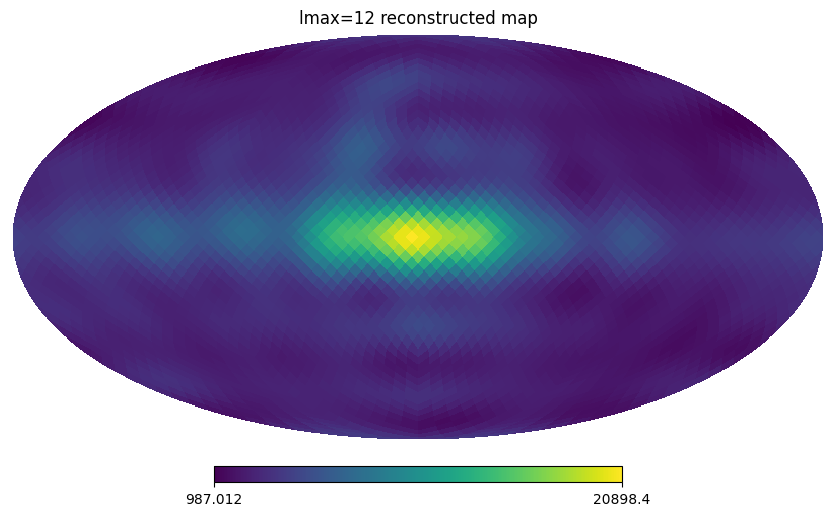

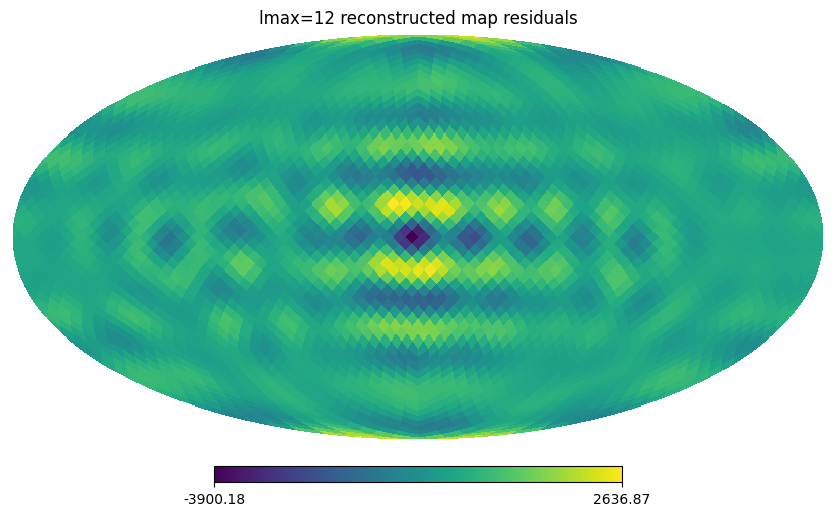

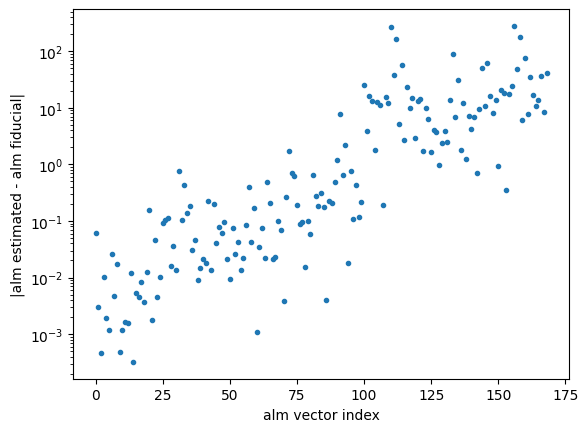

In [3]:
# Set up a fitting model with a different lmax.
lmax_mod = 12
ylm_mat_mod = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax_mod)

mat_A_mod = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax_mod, 
    Ntau=npix, 
    Nt=npix,
    beam_use=tight_cosbeam
)

# Invert to make map.
mat_W, model_covar = MM.calc_ml_estimator_matrix(
    mat_A=mat_A_mod, 
    mat_N=noise_cov, 
    cov=True
)
model_estimate = mat_W @ noisy_data

# Plot
hp.mollview(ylm_mat_mod@model_estimate, title=f"lmax={lmax_mod} reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate - ylm_mat@fg_alm, title=f"lmax={lmax_mod} reconstructed map residuals")
plt.show()

no_modes = np.min((len(model_estimate), len(fg_alm)))
plt.semilogy(range(no_modes), abs(model_estimate[:no_modes] - fg_alm[:no_modes]), '.')
plt.xlabel("alm vector index")
plt.ylabel("|alm estimated - alm fiducial|")
plt.show()

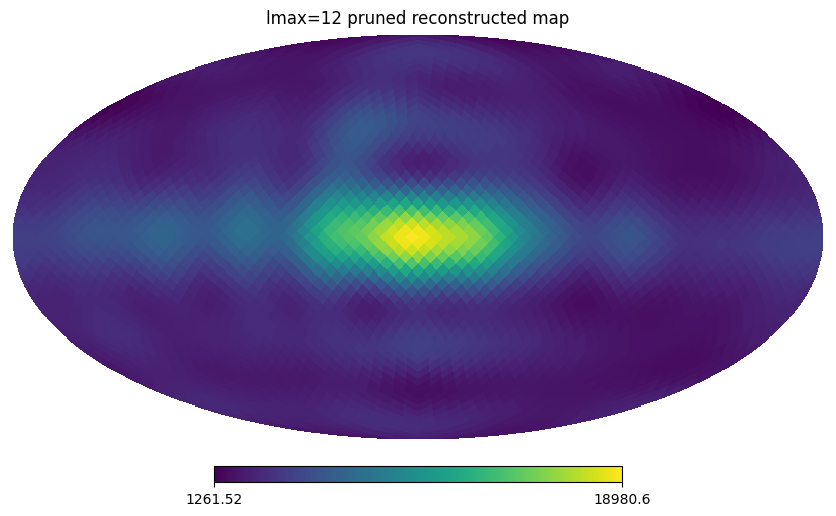

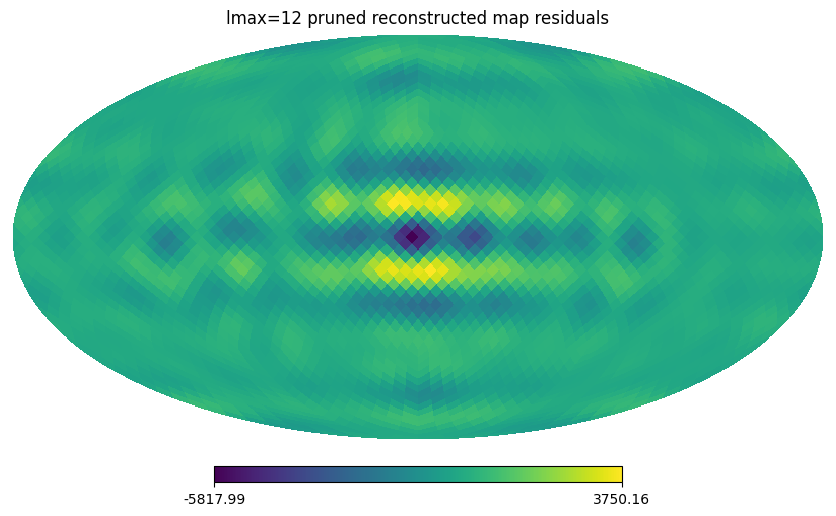

In [4]:
# See what cutting off higher order modes does for the reconstruction.
cutoff_index = 125
model_estimate_pruned = np.array(model_estimate)
model_estimate_pruned[cutoff_index:] = np.zeros(len(model_estimate_pruned[cutoff_index:]))

hp.mollview(ylm_mat_mod@model_estimate_pruned, title=f"lmax={lmax_mod} pruned reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate_pruned - ylm_mat@fg_alm, title=f"lmax={lmax_mod} pruned reconstructed map residuals")
plt.show()

## Foreground power spectrum

Assume isotropy for the unmodelled modes. This means that we pretend they are
drawn from a gaussian distribution given by the variance and mean of each set of
m modes for a given l mode. 

We modify the noise covariance matrix with an extra matrix to include this.

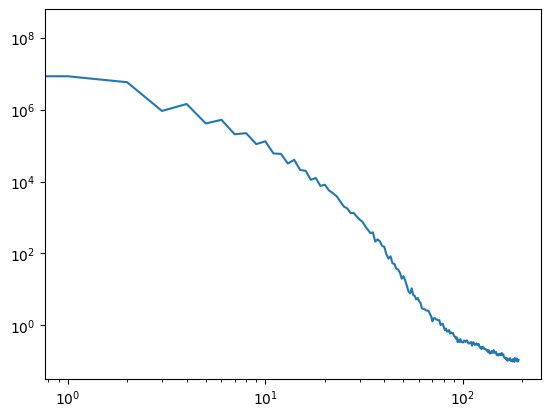

In [5]:
fg_full_map = GlobalSkyModel2016(resolution='low').generate(60)
fg_cl = hp.sphtfunc.anafast(fg_full_map)
plt.loglog(fg_cl)

In [6]:
def calc_basic_unmodelled_mode_matrix(lmod, lmax, nside, foreground_power_spec, beam_mat):
    """
    Calculate the unmodelled mode matrix for the trivial observation strategy and
    no binning of timeseries data.
    """
    npix = hp.nside2npix(nside)
    vectors = hp.pix2vec(nside, ipix=list(range(npix)))
    vectors = np.array(vectors).T
    vector_difference = np.einsum("pi,qi->pq", vectors, vectors)

    val = np.sum([((2*l+1)/(4*np.pi)) * eval_legendre(l, vector_difference) * foreground_power_spec[l] * beam_mat[l,l]**2 for l in range(lmod+1, lmax)], axis=0)
    return val


In [7]:
beam_mat = BF.calc_beam_matrix(nside=nside, lmax=lmax_mod, beam_use=tight_cosbeam)
mat_S = calc_basic_unmodelled_mode_matrix(lmod=lmax_mod, lmax=lmax, foreground_power_spec=fg_cl, nside=nside, beam_mat=beam_mat)

3072 91


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 91


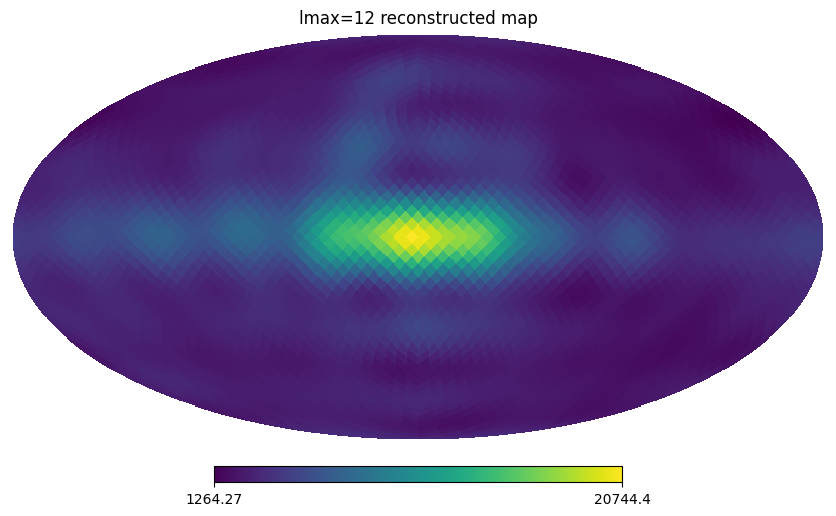

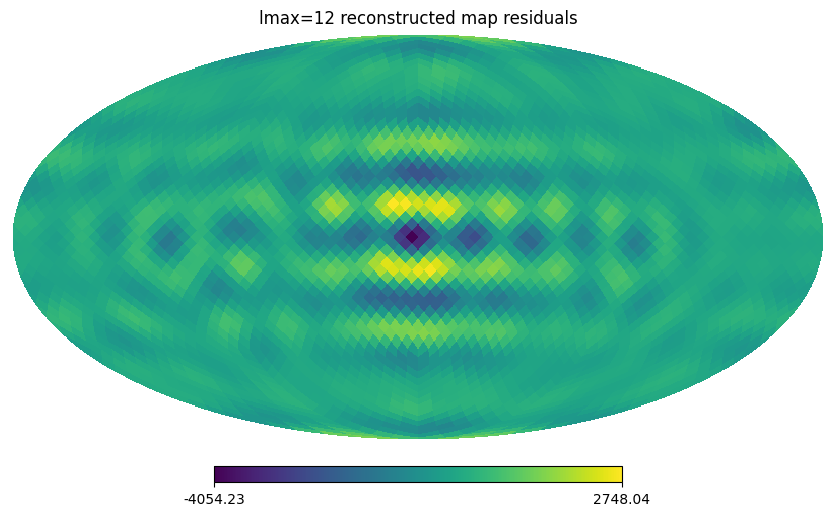

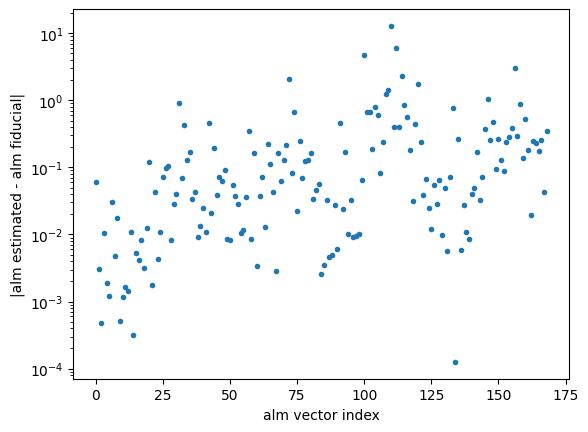

In [8]:
# Set up a fitting model with a different lmax.
lmax_mod = 12
ylm_mat_mod = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax_mod)

mat_A_mod = FM.calc_observation_matrix_all_pix(
    nside=nside, 
    lmax=lmax_mod, 
    Ntau=npix, 
    Nt=npix,
    beam_use=tight_cosbeam
)

# Invert to make map.
mat_W, model_covar = MM.calc_ml_estimator_matrix(
    mat_A=mat_A_mod, 
    mat_N=noise_cov + mat_S, 
    cov=True
)
model_estimate = mat_W @ noisy_data

# Plot
hp.mollview(ylm_mat_mod@model_estimate, title=f"lmax={lmax_mod} reconstructed map")
plt.show()

hp.mollview(ylm_mat_mod@model_estimate - ylm_mat@fg_alm, title=f"lmax={lmax_mod} reconstructed map residuals")
plt.show()

no_modes = np.min((len(model_estimate), len(fg_alm)))
plt.semilogy(range(no_modes), abs(model_estimate[:no_modes] - fg_alm[:no_modes]), '.')
plt.xlabel("alm vector index")
plt.ylabel("|alm estimated - alm fiducial|")
plt.show()

## Foreground phase rotation

This reconstruction seems significantly worse than the previous one. A possible 
reason is that the unmodelled modes are not isotropic and gaussian. To visualise 
whether they are, rotate the phases of the alm in the default foregrounds and
see how much they change.

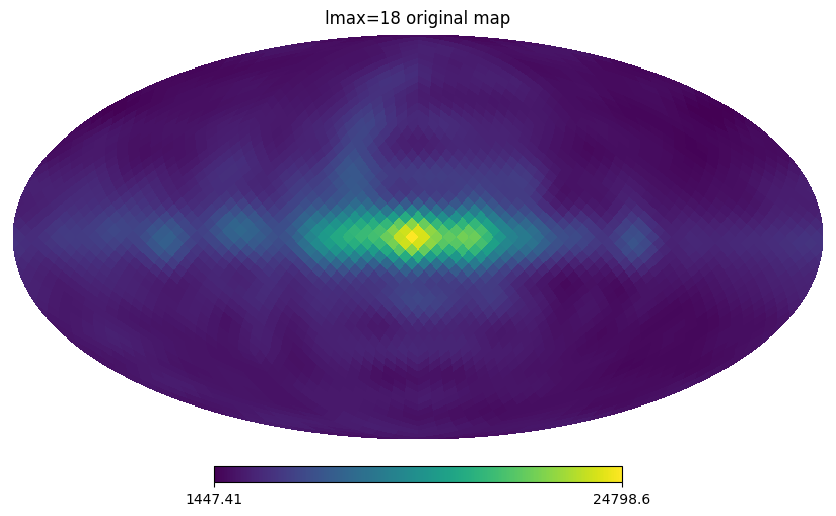

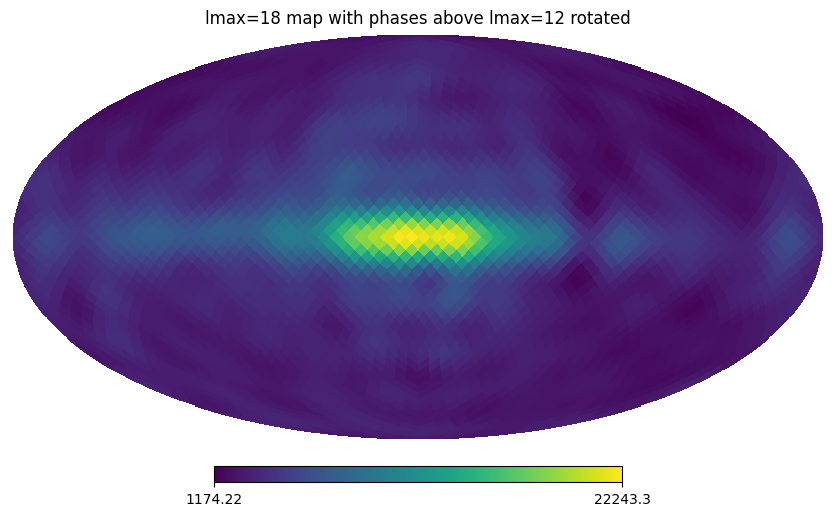

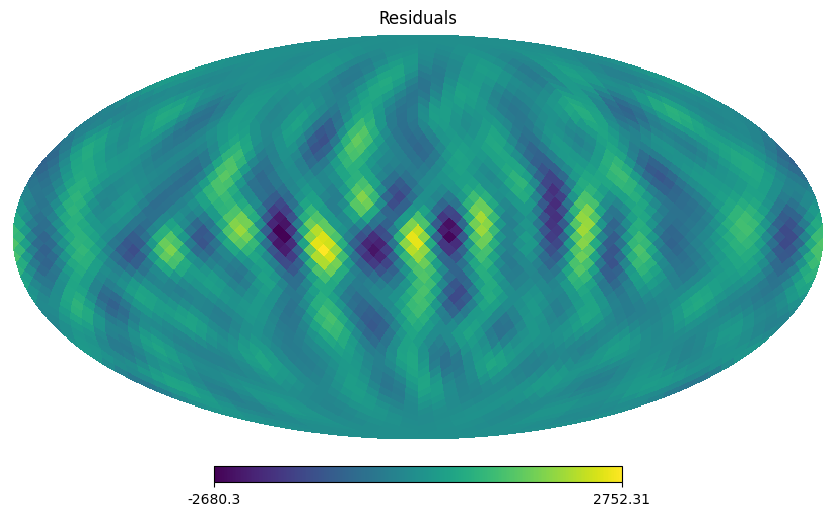

In [20]:
fg_alm = SM.foreground_gdsm_alm(nu=60, lmax=18, nside=nside)
fg_alm_complex = SH.RealSphericalHarmonics().real2ComplexALM(fg_alm)

# Rotate the final 99 complex alm's phases.
random_phases = np.random.uniform(0, 2*np.pi, size=99)
rotated_alm_complex = np.array(fg_alm_complex)
rotated_alm_complex[-99:] = fg_alm_complex[-99:] * np.exp(1j * random_phases)

# Convert back to real spherical harmonics
rotated_alm = SH.RealSphericalHarmonics().complex2RealALM(rotated_alm_complex)

hp.mollview(ylm_mat@fg_alm, title=f"lmax=18 original map")
plt.show()
hp.mollview(ylm_mat@rotated_alm, title=f"lmax=18 map with phases above lmax=12 rotated")
plt.show()
hp.mollview(ylm_mat@(fg_alm-rotated_alm), title=f"Residuals")
plt.show()

